# Basic Levelness Annotation Creation for a Crowd Sourced Gold Standard

First, A data set of the categories used in the experiment is created. It has the original annotator agreements on basic-levelness (3 of 3 agree = True, 2 of 3 agree = False). The original label for basic_levelness is binary. A new value for basic levelness is added, ranging from 0-1. It acts as a ratio of the sample population's display of basic level effects (BLEs), meaning, within a WordNet path, the amount of people that experienced the BLE for a specific category in the path versus those that did not.

Second, All the reaction times of participants are entered in the same data frame. Each participant adds two values per synset; reaction time and accuracy. The population means are noted, along-side the sample standard deviation from the mean. Third, The synsets are rated by using a depth-first, recursive algorithm exploring the WordNet network. Starting from a superordinate (of which there are 5), we follow down the paths, passing a potential basic level, onto a subordinate, where reaction times are compared.

## 1. Data Preparation

Import Experiment Results.

Create data frame to be annotated (with correct WordNet synsets).
Create data frame with rts.


In [2]:
from nltk.corpus import wordnet as wn
import pandas as pd
import os, csv

# specify experiment results folder in question
experiment_data_folder = os.path.abspath("../Past_experiments/Pilot2/collected_data/experiment_data")

# specify experiment 'project file'
experiment_project = pd.read_csv(os.path.abspath("../Past_experiments/Pilot2/Rosch7_Thesis_Experiment/Thesis_Experiment.csv"))

# all superordinate categories
branches = experiment_project["hypernym"].unique()

experiment_project.head()


,hypernym,bl,bl_name,bl_certainty,hyponym,hypernym_def,bl_def,hyponym_def,hyponym_img,cont_flag
0,hand_tool.n.01,awl.n.01,awl,True,bradawl.n.01,missing,a pointed tool for marking surfaces or for pun...,an awl for making small holes for brads or sma...,bradawl.n.01.png,True
1,hand_tool.n.01,file.n.04,file,True,nailfile.n.01,missing,a steel hand tool with small sharp teeth on so...,a small flat file for shaping the nails,nailfile.n.01.png,False
2,hand_tool.n.01,hammer.n.02,hammer,True,carpenter's_hammer.n.01,missing,a hand tool with a heavy rigid head and a hand...,a hammer with a cleft at one end for pulling n...,carpenter's_hammer.n.01.png,False
3,hand_tool.n.01,can_opener.n.01,can_opener,True,church_key.n.01,missing,a device for cutting cans open,can opener that has a triangular pointed end t...,church_key.n.01.png,False
4,hand_tool.n.01,plane.n.05,plane,True,smooth_plane.n.01,missing,a carpenter's hand tool with an adjustable bla...,a small plane for finish work,smooth_plane.n.01.png,False


In [3]:
def get_depth_wn(syns):
    # to do
    return 1

In [22]:
#collect array of branches as names of data frames
brs = []
syns = []
gloss = []
ecert = []
bls_old = []
bls = []
accs = []

# writing the superordinate category row

for branch in branches:
     brs.append(branch)
     syns.append(branch)
     gloss.append(wn.synset(branch).definition())
     ecert.append(True)
     bls_old.append(0)
     bls.append(0)
     accs.append(1)

for i, row in experiment_project.get(['hypernym', 'bl', 'hyponym', 'bl_certainty']).iterrows():
     bl = row['bl']
     sub = row['hyponym']
     br = row['hypernym']

     # writing the bl category row
     brs.append(br)
     syns.append(bl)
     gloss.append(wn.synset(bl).definition())
     ecert.append(certainty)
     bls_old.append(1)

     if certainty:
          bls.append(1)
          accs.append(1)
     else:
          bls.append(0.7)
          accs.append(0.5)

     # writing the subordinate category row
     brs.append(br)
     syns.append(sub)
     gloss.append(wn.synset(sub).definition())
     certainty = row['bl_certainty']
     ecert.append(certainty)
     bls_old.append(0)

     if certainty:
          bls.append(0)
          accs.append(1)
     else:
          bls.append(0.3)
          accs.append(0.5)


d = {'branch': brs,
     'synset': syns,
     'glossary': gloss,
     'expert_certainty': ecert,
     'old_bl_label': bls_old,
     'blness': bls,
     'accuracy': accs}


gold_standard_without_reaction_times = pd.DataFrame(data=d).sort_values(by=['synset'])
gold_standard_without_reaction_times.to_csv("../Past_experiments/Pilot2/computed_data/Gold_Standard_without_rt.csv")
print(gold_standard_without_reaction_times.head())

137


In [141]:
participant_files = [os.path.join(experiment_data_folder, file) for file in os.listdir(experiment_data_folder)]

gold_standard_with_reaction_times = gold_standard_without_reaction_times

for i in range(1,len(participant_files)+1):
    gold_standard_with_reaction_times[f'p{i}_rt'] = [-1 for x,r in gold_standard_without_reaction_times.iterrows()]
    gold_standard_with_reaction_times[f'p{i}_acc'] = [-1 for x,r in gold_standard_without_reaction_times.iterrows()]

p_id = 0

for file in participant_files:
    p_id += 1
    rt_col = f"p{p_id}_rt"
    acc_col = f"p{p_id}_acc"

    part_df = pd.read_csv(file, sep=" ",names=['index','synset','lvl', 'img', 'type', 'accuracy', 'rt'])
    part_df['accuracy'] = abs(part_df['accuracy']-2)
    part_df['synset'] = part_df['synset'].transform(lambda x: x[:-5])
    part_df = part_df.get(["synset", "type", 'accuracy', 'rt']).sort_values(by=['synset'])
    

    for i, row in gold_standard_without_reaction_times.iterrows():
        syn = row['synset']
        strip_syn = syn[:-5].replace("'", '').replace("-", '')
        matching = part_df.loc[part_df['synset'] == strip_syn]
        
        # just to make sure that no synset is overlooked because of formatting
        if(len(matching)==0):
            print('alarm')
            print(strip_syn)
        
        else:
            acc_val = matching['accuracy'].mean()
            rt_val = matching['rt'].mean()

            gold_standard_with_reaction_times.at[i, rt_col] = rt_val
            gold_standard_with_reaction_times.at[i, acc_col] = acc_val

mean_rt = []
median_rt = []
mean_acc = []
std_dev = []
rt_cols = [f"p{i}_rt" for i in range(1,len(participant_files)+1)]
acc_cols = [f"p{i}_acc" for i in range(1,len(participant_files)+1)]


for i, row in gold_standard_with_reaction_times.iterrows():
    rts = gold_standard_with_reaction_times.loc[i,rt_cols]
    mn = rts.mean()
    md = rts.median()
    std = rts.std()
    mean_rt.append(mn)
    median_rt.append(md)
    std_dev.append(std)
    accs = gold_standard_with_reaction_times.loc[i,acc_cols].mean()
    mean_acc.append(accs)

gold_standard_with_reaction_times['sample_mean_rt'] = mean_rt
gold_standard_with_reaction_times['sample_median_rt'] = median_rt
gold_standard_with_reaction_times['sample_mean_acc'] =mean_acc
gold_standard_with_reaction_times['sample_std_deviation'] =std_dev

In [90]:
print(gold_standard_with_reaction_times.head())
gold_standard_with_reaction_times.to_csv("../Past_experiments/Pilot2/computed_data/Gold_Standard_with_rt.csv")

                     branch                synset  \
68  musical_instrument.n.01  acoustic_guitar.n.01   
31        edible_fruit.n.01            apple.n.01   
96           furniture.n.01         armchair.n.01   
90           furniture.n.01          armoire.n.01   
5            hand_tool.n.01              awl.n.01   

                                             glossary  expert_certainty  \
68         sound is not amplified by electrical means              True   
31  fruit with red or yellow or green skin and swe...              True   
96         chair with a support on each side for arms              True   
90  a large wardrobe or cabinet; originally used f...              True   
5   a pointed tool for marking surfaces or for pun...             False   

    old_bl_label  blness  accuracy  p1_rt  p1_acc  p2_rt  ...  p21_acc  \
68             0     0.0       1.0  551.0     1.0  410.5  ...      1.0   
31             1     1.0       1.0  437.5     1.0  630.0  ...      1.0   
96      

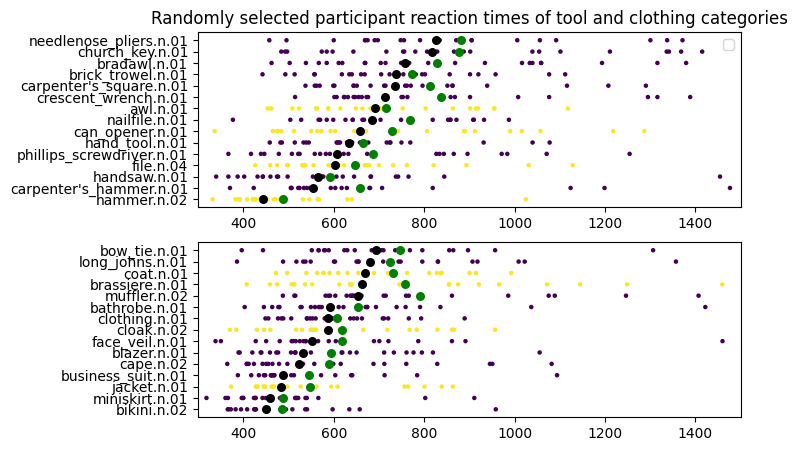

In [126]:
import matplotlib.pyplot as gg

data_cloth = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["branch"]=="hand_tool.n.01"].head(15).sort_values(by=['sample_median_rt'])
data_cloth = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["branch"]=="clothing.n.01"].head(15).sort_values(by=['sample_median_rt'])

plot, (ax, ax2) = gg.subplots(nrows=2, figsize=(7, 5))

for p in range(1,len(participant_files)+1):
    ax.scatter(y=data_tools['synset'], x=data_tools[f'p{p}_rt'], s=5, c=data_tools["old_bl_label"])


ax.scatter(x=data_tools["sample_mean_rt"], y=data_tools["synset"], s=30, c="green")
ax.scatter(x=data_tools["sample_median_rt"], y=data_tools["synset"],  s=30, c="black")

for p in range(1,len(participant_files)+1):
    ax2.scatter(y=data_cloth['synset'], x=data_cloth[f'p{p}_rt'], s=5, c=data_cloth["old_bl_label"])


ax2.scatter(x=data_cloth["sample_mean_rt"], y=data_cloth["synset"], s=30, c="green")
ax2.scatter(x=data_cloth["sample_median_rt"], y=data_cloth["synset"],  s=30, c="black")


ax.set_title("Randomly selected participant reaction times of tool and clothing categories")
handles, labels = ax.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlim([300,1500])
ax2.set_xlim([300,1500])
gg.show()

Participant reaction time means are mostly slower than medians and are influenced by outliers.
No apparent clusters can be made out in this data. The value used to compute further ratings is the median.

In [165]:
import numpy as np

# need to sample 22 from full expert annotator agreement cases to balance the comparison
comp_data1 = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["expert_certainty"] == False]
comp_data2 = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["expert_certainty"] == True].sample(22)
comp_data = comp_data1.append(comp_data2)

score_by_std_dev = [np.floor(x/100) for x in comp_data["sample_std_deviation"]]
ann_agree = [x*1 for x in comp_data["expert_certainty"]]
mean_accuracies = [np.floor(a*10)/10 for a in comp_data["sample_mean_acc"]]

pd.crosstab(ann_agree, [mean_accuracies], rownames=['Expert annotator agreement'], colnames=["Sample mean accuracy"])


C:\Users\ht409\AppData\Local\Temp\ipykernel_30916\1548773267.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_data = comp_data1.append(comp_data2)


Sample mean accuracy,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
Expert annotator agreement,,,,,,,,
0,0,1,1,4,2,3,11,0
1,1,0,0,2,3,2,12,2


## 2. Data Evaluation

Define depth-first recursive function to walk WordNet paths.
Generate annotation scores.
